# Comparison of Different Regressors for Fiber Orientation

This notebook evaluates various regression models with 5-fold cross-validation:
1. Support Vector Regression (SVR)
2. Random Forest
3. XGBoost
4. Linear Models (Ridge, Lasso)

In [ ]:
import os
import sys
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Regressors
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
import xgboost as xgb

# Add src directory to Python path
sys.path.append(os.path.abspath('../../src'))
from fiber_predictor.svr_hog.feature_extraction import HogFeatureExtractor
from fiber_predictor.svr_hog.data_processing import HogDataset

In [6]:
# Data preparation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Load data
dataset = HogDataset(
    labels_path="../images/bio/labels.csv",
    file_dir="../images/bio/",
    grid_quotient=np.arange(1, 6),
    orientations=8,
    augment_whole_dataset=True
)

# Extract features
X = []
y = []
for idx in range(len(dataset)):
    _, features, angle = dataset[idx]
    X.append(features.numpy())
    y.append(angle)

X = np.array(X)
y = np.array(y)

# Preprocess
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Total samples: {len(y)}")
print(f"Original features: {X.shape[1]}")
print(f"PCA features: {X_pca.shape[1]}")

Total samples: 4711
Original features: 440
PCA features: 138


In [ ]:
# Function to evaluate and track model results
def evaluate_model(model_name, model, param_distributions, n_iter=20):
    random_search = RandomizedSearchCV(
        model, param_distributions, 
        n_iter=n_iter,
        cv=cv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1, 
        verbose=2,
        random_state=42
    )
    random_search.fit(X_pca, y)
    
    print(f"\n{model_name} Results:")
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best MAE: {-random_search.best_score_:.2f}°")
    
    return {
        'model': model_name,
        'params': random_search.best_params_,
        'mae': -random_search.best_score_,
        'std': random_search.cv_results_['std_test_score'][random_search.best_index_]
    }



In [9]:
# SVR evaluation
start_time = time.time()
svr_params = {
    'kernel': ['rbf', 'poly'],
    'C': np.logspace(-2, 3, 10),
    'gamma': ['scale', 'auto'] + list(np.logspace(-4, 0, 5)),
    'epsilon': [0.01, 0.05, 0.1, 0.2]
}
svr_results = evaluate_model('SVR', SVR(), svr_params)
svr_results['time'] = time.time() - start_time
print(f"SVR training time: {svr_results['time']:.2f} seconds")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END C=278.2559402207126, epsilon=0.01, gamma=0.0001, kernel=poly; total time=   2.8s
[CV] END C=278.2559402207126, epsilon=0.01, gamma=0.0001, kernel=poly; total time=   2.8s
[CV] END C=278.2559402207126, epsilon=0.01, gamma=0.0001, kernel=poly; total time=   2.8s
[CV] END C=21.544346900318846, epsilon=0.01, gamma=0.0001, kernel=poly; total time=   2.8s
[CV] END C=278.2559402207126, epsilon=0.01, gamma=0.0001, kernel=poly; total time=   2.9s
[CV] END C=21.544346900318846, epsilon=0.01, gamma=0.0001, kernel=poly; total time=   2.9s
[CV] END C=278.2559402207126, epsilon=0.01, gamma=0.0001, kernel=poly; total time=   2.9s
[CV] END C=21.544346900318846, epsilon=0.01, gamma=0.0001, kernel=poly; total time=   2.8s
[CV] END C=21.544346900318846, epsilon=0.01, gamma=0.0001, kernel=poly; total time=   2.9s
[CV] END C=21.544346900318846, epsilon=0.01, gamma=0.0001, kernel=poly; total time=   3.0s
[CV] END C=0.03593813663804628, e

In [10]:
# Random Forest evaluation
start_time = time.time()
rf_params = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [5, 10, 15, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
rf_results = evaluate_model('Random Forest', RandomForestRegressor(random_state=42), rf_params)
rf_results['time'] = time.time() - start_time
print(f"Random Forest training time: {rf_results['time']:.2f} seconds")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   2.0s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   2.0s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   2.1s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   1.9s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   1.9s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   4.6s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   4.6s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=15

/opt/homebrew/Caskroom/miniconda/base/envs/fiber-orientation/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
23 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/fiber-orientation/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/fiber-orientation/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/homebrew/Caskroom/miniconda/bas


Random Forest Results:
Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15}
Best MAE: 19.10°
Random Forest training time: 64.14 seconds


In [11]:
# XGBoost evaluation
start_time = time.time()
xgb_params = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}
xgb_results = evaluate_model('XGBoost', xgb.XGBRegressor(random_state=42), xgb_params)
xgb_results['time'] = time.time() - start_time
print(f"XGBoost training time: {xgb_results['time']:.2f} seconds")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.9; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=

/opt/homebrew/Caskroom/miniconda/base/envs/fiber-orientation/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.7; total time=  10.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.7; total time=  11.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=6, n_estimators=200, subsample=0.8; total time=   8.7s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.7; total time=  14.0s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.7; total time=  10.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=6, n_estimators=200, subsample=0.8; total time=   8.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=6, n_estimators=200, subsample=0.8; total time=   9.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=6, n_estimators=200, subsample=0.8; total time=   8

In [14]:
# Lasso evaluation
start_time = time.time()
lasso_params = {
    'alpha': np.logspace(-4, 2, 20),
    'max_iter': [1000, 2000, 3000],
    'tol': [1e-4, 1e-3, 1e-2],
    'selection': ['cyclic', 'random']
}
lasso_results = evaluate_model('Lasso', Lasso(), lasso_params)
lasso_results['time'] = time.time() - start_time
print(f"Lasso training time: {lasso_results['time']:.2f} seconds")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END alpha=0.615848211066026, max_iter=2000, selection=cyclic, tol=0.01; total time=   0.0s[CV] END alpha=0.615848211066026, max_iter=2000, selection=cyclic, tol=0.01; total time=   0.0s

[CV] END alpha=0.615848211066026, max_iter=2000, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.615848211066026, max_iter=2000, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.615848211066026, max_iter=2000, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.00042813323987193956, max_iter=2000, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=0.00042813323987193956, max_iter=2000, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=5.455594781168514, max_iter=3000, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=5.455594781168514, max_iter=3000, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=5.455594781168514, max_iter=3000, selecti

/opt/homebrew/Caskroom/miniconda/base/envs/fiber-orientation/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.824e+04, tolerance: 9.795e+02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/fiber-orientation/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.914e+04, tolerance: 9.890e+02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/fiber-orientation/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want 

[CV] END alpha=0.29763514416313164, max_iter=1000, selection=random, tol=0.01; total time=   0.0s
[CV] END alpha=11.288378916846883, max_iter=3000, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=11.288378916846883, max_iter=3000, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=11.288378916846883, max_iter=3000, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=0.0008858667904100823, max_iter=1000, selection=random, tol=0.0001; total time=   0.3s
[CV] END alpha=11.288378916846883, max_iter=3000, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=0.0008858667904100823, max_iter=1000, selection=random, tol=0.0001; total time=   0.3s
[CV] END alpha=11.288378916846883, max_iter=3000, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=0.01623776739188721, max_iter=3000, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.01623776739188721, max_iter=3000, selection=cyclic, tol=0.001; total time=   0.0s
[CV] 

/opt/homebrew/Caskroom/miniconda/base/envs/fiber-orientation/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.665e+04, tolerance: 9.795e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END alpha=0.00042813323987193956, max_iter=2000, selection=cyclic, tol=0.0001; total time=   0.6s


/opt/homebrew/Caskroom/miniconda/base/envs/fiber-orientation/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.574e+05, tolerance: 9.890e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END alpha=0.0001, max_iter=3000, selection=random, tol=0.0001; total time=   0.8s
[CV] END alpha=0.0001, max_iter=3000, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=3000, selection=random, tol=0.0001; total time=   0.4s
[CV] END alpha=0.0001, max_iter=3000, selection=random, tol=0.0001; total time=   0.0s

Lasso Results:
Best parameters: {'tol': 0.0001, 'selection': 'cyclic', 'max_iter': 1000, 'alpha': np.float64(0.01623776739188721)}
Best MAE: 20.48°
Lasso training time: 1.40 seconds


In [12]:
# Ridge evaluation
start_time = time.time()
ridge_params = {'alpha': np.logspace(-4, 2, 20)}
ridge_results = evaluate_model('Ridge', Ridge(), ridge_params)
ridge_results['time'] = time.time() - start_time
print(f"Ridge training time: {ridge_results['time']:.2f} seconds")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................alpha=0.00020691380811147902; total time=   0.0s
[CV] END .......................alpha=0.00020691380811147902; total time=   0.0s
[CV] END .......................alpha=0.00020691380811147902; total time=   0.0s
[CV] END .......................alpha=0.00042813323987193956; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................alpha=0.00042813323987193956; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................alpha=0.00020691380811147902; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................alpha=0.00020691380811147902; total time=   0.0s
[CV] END .......................alpha=0.0004281

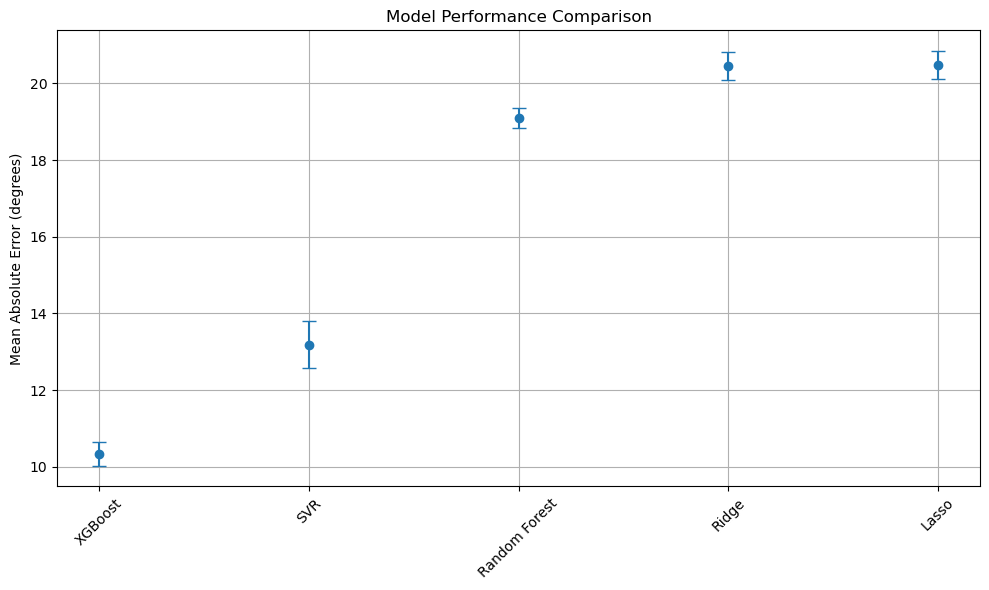


Detailed Results:


,model,params,mae,std,time
2,XGBoost,"{'subsample': 0.9, 'n_estimators': 300, 'max_d...",10.342046,0.310933,78.510727
0,SVR,"{'kernel': 'rbf', 'gamma': 'scale', 'epsilon':...",13.185709,0.615814,74.388793
1,Random Forest,"{'n_estimators': 300, 'min_samples_split': 2, ...",19.096205,0.261280,64.138163
3,Ridge,{'alpha': 100.0},20.453880,0.356296,0.543492
4,Lasso,"{'tol': 0.0001, 'selection': 'cyclic', 'max_it...",20.483579,0.360604,1.403451


In [15]:
# Compile and compare results
results = [svr_results, rf_results, xgb_results, ridge_results, lasso_results]
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('mae')

# Plot comparison
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(results_df)), 
             results_df['mae'], 
             yerr=results_df['std'],
             fmt='o',
             capsize=5)

plt.xticks(range(len(results_df)), results_df['model'], rotation=45)
plt.ylabel('Mean Absolute Error (degrees)')
plt.title('Model Performance Comparison')
plt.grid(True)
plt.tight_layout()
plt.show()

# Save results
print("\nDetailed Results:")
display(results_df)
results_df.to_csv('../models/svr_hog/regressor_comparison.csv', index=False)

# Save best model config
best_config = {
    'model': results_df.iloc[0]['model'],
    'parameters': results_df.iloc[0]['params'],
    'mae': float(results_df.iloc[0]['mae']),
    'std': float(results_df.iloc[0]['std'])
}

with open('../models/svr_hog/best_regressor.json', 'w') as f:
    json.dump(best_config, f, indent=4)